# Backtest Strategy

In [95]:
from datetime import datetime, timedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

def save_data_to_df(response_json):
    data = []
    for position in response_json.get('LP_positions', []):
        burn_data = position.get('burn', {})
        info_data = position.get('info', {})
        mint_data = position.get('mint', {})
        swap_data = position.get('swap', {})

        data.append({
            'start': info_data.get('start'),
            'end': info_data.get('end'),
            'curr_price': burn_data.get('burn_price') / 1e10,
            'lower_price': info_data.get('lower_price'),
            'upper_price': info_data.get('upper_price'),
            'X_start': info_data.get('X_start'),
            'Y_start': info_data.get('Y_start'),
            'liquidity': mint_data.get('liquidity'),
            'X_left': mint_data.get('X_left')/1e8,
            'X_mint': mint_data.get('X_mint')/1e8,
            'Y_left': mint_data.get('Y_left')/1e18,
            'Y_mint': mint_data.get('Y_mint')/1e18,
            'X_fee': burn_data.get('X_fee')/1e8,
            'X_reserve': burn_data.get('X_reserve')/1e8,
            'Y_fee': burn_data.get('Y_fee')/1e18,
            'Y_reserve': burn_data.get('Y_reserve')/1e18,
            'APR': info_data.get('APR'),
            'Impermanent_loss': info_data.get('Impermanent_loss'),
            'PnL': info_data.get('PnL'),
            'Yield': info_data.get('Yield')
        })

    final_result = response_json.get('final_result', {})
    final_result_data = {
        'final_PnL': final_result.get('PnL'),
        'final_fee_value': final_result.get('fee_value')/1e18,
        'final_fee_yield': final_result.get('fee_yield'),
        'final_impermanent_loss': final_result.get('impermanent_loss'),
        'final_portfolio_value_end': final_result.get('portfolio_value_end')/1e18,
        'final_portfolio_value_start': final_result.get('portfolio_value_start')/1e18
    }

    data_df = pd.DataFrame(data)
    final_result_df = pd.DataFrame([final_result_data])

    return data_df, final_result_df

def save_data_to_csv(data_df):
    import os
    # Construct the filename
    filename = f"{agent}_{pool_id}_{start_date}_to_{end_date}.csv"

    # Define the directory where the file will be saved
    directory = "/Users/idrees/Code/ILP-Framework/model_outdir_csv/backtest"

    # Create the full file path
    file_path = os.path.join(directory, filename)

    # Save the DataFrame to CSV
    data_df.to_csv(file_path, index=False)

def plot_prices_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['lower_price'], label='Lower Price')
    plt.plot(data_df['start'], data_df['upper_price'], label='Upper Price')
    plt.plot(data_df['start'], data_df['curr_price'], label='Current Price')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Ranges Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_apr_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['APR'])
    plt.xlabel('Date')
    plt.ylabel('APR')
    plt.title('APR Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_il_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Impermanent_loss'])
    plt.xlabel('Date')
    plt.ylabel('Impermanent Loss')
    plt.title('Impermanent Loss Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_pnl_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['PnL'])
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_yield_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Yield'])
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.title('Yield Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def price_to_raw_tick(price):
    return math.floor(math.log(price) / math.log(1.0001))

def price_to_valid_tick(price, tick_spacing=60):
    raw_tick = math.floor(math.log(price, 1.0001))
    remainder = raw_tick % tick_spacing
    if remainder != 0:
        # Round to the nearest valid tick, considering tick spacing.
        raw_tick += tick_spacing - remainder if remainder >= tick_spacing // 2 else -remainder
    return raw_tick

def datetime_to_unix_timestamp(date_str, format='%Y-%m-%d %H:%M:%S'):
    dt = datetime.strptime(date_str, format)
    return int(time.mktime(dt.timetuple()))

def backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent):
    current_date = datetime.strptime(start_date, '%d-%m-%y')
    end_date = datetime.strptime(end_date, '%d-%m-%y')

    all_positions = []

    while current_date <= end_date:
        curr_date_str = current_date.strftime('%Y-%m-%d')
        # Step 3: Predict new positions
        ddpg_action, ppo_action = get_inference(ddpg_agent_path, ppo_agent_path, pool_id, curr_date_str)
        
        # Step 4: Rebalance portfolio
        start_interval = current_date
        end_interval = current_date + timedelta(days=rebalancing_frequency)
        start_date_str = start_interval.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_interval.strftime('%Y-%m-%d %H:%M:%S')

        start_timestamp = datetime_to_unix_timestamp(start_date_str)
        end_timestamp = datetime_to_unix_timestamp(end_date_str)

        if agent == "ddpg":
            price_lower = ddpg_action['price_lower']
            price_upper = ddpg_action['price_upper']
            
        else:
            price_lower = ppo_action['price_lower']
            price_upper = ppo_action['price_upper']
            
        print(f'price_lower: {price_lower} & price_upper: {price_upper}')
        # Collect all positions in a list
        all_positions.append({
            "start": start_timestamp,
            "end": end_timestamp,
            "lower_tick": price_to_valid_tick(price_lower,1),
            "upper_tick": price_to_valid_tick(price_upper,1),
        })


        # Move to the next rebalancing date
        current_date += timedelta(days=rebalancing_frequency)

    # Step 5: Send all positions to the simulator API in a single request
    response = simulate_position(X_reserve, Y_reserve, all_positions)
    response_json = response.json()

    if 'LP_positions' not in response_json:
        print(f"Voyager API response:{response_json}")
        return pd.DataFrame(), pd.DataFrame()

    # Process the response to save data to a DataFrame
    data_df, results_df = save_data_to_df(response_json)

    return data_df, results_df


def get_inference(ddpg_agent_path='model_storage/ddpg/ddpg_1', ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm', pool_id="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", date_str='2024-05-05', api_key='igVj0yhN8gw9rlv'):
    url = "https://ilp.tempestfinance.xyz/api/v1/predict-action/"
    headers = {
        'Content-Type': 'application/json',
        'x-api-key': api_key
    }
    data = {
        "pool_id": pool_id,
        "ddpg_agent_path": ddpg_agent_path,
        "ppo_agent_path": ppo_agent_path,
        "date_str": date_str
    }
    # Make the POST request
    response = requests.post(url, json=data, headers=headers)
    
    # Check if the request was successful
    if response.status_code == 200:
        try:
            response_json = response.json()
            ddpg_action = response_json.get('ddpg_action', {})
            ppo_action = response_json.get('ppo_action', {})
            return ddpg_action, ppo_action
        except ValueError:
            print("Failed to parse JSON response.")
            return None, None
    else:
        print(f"Request failed with status code {response.status_code}: {response.text}")
        return None, None


def simulate_position(X_reserve, Y_reserve, positions):
    print(positions)
    vector = {
        "datatype": "raw",
        "fee_tier": 1000,
        "pool": "0x109830a1aaad605bbf02a9dfa7b0b92ec2fb7daa",
        "token0": X_reserve,
        "token1": Y_reserve,
        "range_type": "tick",
        "positions": positions
    }
    url = "https://voyager-simulation.tempestfinance.xyz/MVP"
    response = requests.post(url, json=vector)
    print(response.text)

    return response

start_date = '01-01-24'
end_date = '01-08-24'
ddpg_agent_path = 'model_storage/ddpg/ddpg_1'
ppo_agent_path = 'model_storage/ppo/lstm_actor_critic_batch_norm'
pool_id = "0x109830a1aaad605bbf02a9dfa7b0b92ec2fb7daa"
agent = "ppo"


X_reserve = 5e18
Y_reserve = 5e18
rebalancing_frequency = 1


data_df, results_df = backtest_ilp(start_date, end_date, X_reserve, Y_reserve, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent)
save_data_to_csv(data_df)


price_lower: 0.6041455805119654 & price_upper: 1.8146942916061124
price_lower: 1.039023147059288 & price_upper: 1.3805716355573887
price_lower: 0.1822016082913363 & price_upper: 2.2371276308695673
price_lower: 0.8716528675767772 & price_upper: 1.5479353490214018
price_lower: 0.788704700159128 & price_upper: 1.6310596229565673
price_lower: 0.6762466888630568 & price_upper: 1.744001334698062
price_lower: 1.0778132531198428 & price_upper: 1.3428301683102188
price_lower: 0.4726296610160773 & price_upper: 1.947190205397799
price_lower: 0.5755311121640929 & price_upper: 1.8441157282596505
price_lower: 1.1326942936721487 & price_upper: 1.2884933562519256
price_lower: 0.711068412302235 & price_upper: 1.7100690138435535
price_lower: 0.5671071992050095 & price_upper: 1.8540367185362534
price_lower: 0.8469744081074929 & price_upper: 1.5743451088037803
price_lower: 0.6184910145089623 & price_upper: 1.8037928346509882
price_lower: 0.5218659447243887 & price_upper: 1.9006434407740231
price_lower: 0.

In [97]:
results_df.head()

,final_PnL,final_fee_value,final_fee_yield,final_impermanent_loss,final_portfolio_value_end,final_portfolio_value_start
0,9.838886,1.080808,9.982496,0.143611,10.811482,10.827031


In [98]:
data_df.head(10)

,start,end,curr_price,lower_price,upper_price,X_start,Y_start,liquidity,X_left,X_mint,Y_left,Y_mint,X_fee,X_reserve,Y_fee,Y_reserve,APR,Impermanent_loss,PnL,Yield
0,1704049200,1704135600,1.151812e-10,0.604125,1.814609,5.000000e+18,5.000000e+18,20925148460700065792,-5.081270e-03,3.964865e+10,1.616389e-04,6.191854,1.945780e+04,3.963672e+10,0.000004,6.193228,0.000285,7.813168e-07,7.813168e-07,0.000054
1,1704135600,1704222000,1.151967e-10,1.038937,1.380553,3.963674e+18,6.193232e+18,73245518221719633920,3.353425e+06,5.909802e+10,1.580500e-13,3.951047,1.292271e+06,5.905228e+10,0.000154,3.956316,0.001198,3.281681e-06,3.281681e-06,0.002818
2,1704222000,1704308400,1.151845e-10,0.182188,2.237054,5.905358e+18,3.956470e+18,11329630338001213440,-3.352080e-03,2.981002e+10,7.184277e-04,7.324174,6.390474e+08,2.981558e+10,0.029201,7.323534,0.000114,3.129986e-07,3.129986e-07,0.955602
3,1704308400,1704394800,1.152124e-10,0.871627,1.547867,3.045463e+18,7.352735e+18,37833908239073968128,1.897133e+06,4.842177e+10,-2.650930e-13,5.282773,5.997990e+04,4.837915e+10,0.000012,5.287683,0.001995,5.466487e-06,5.466487e-06,0.000172
4,1704394800,1704481200,1.151835e-10,0.788685,1.630971,4.837921e+18,5.287695e+18,30465614565276319744,-6.446890e-03,4.527728e+10,3.866982e-05,5.645001,2.942563e+05,4.531282e+10,0.000030,5.640906,0.001723,4.720852e-06,4.720852e-06,0.000586
5,1704481200,1704567600,1.152266e-10,0.676191,1.743984,4.531311e+18,5.640936e+18,24029182883323576320,-5.568820e-03,4.193812e+10,4.851867e-05,6.029593,5.086377e+05,4.189625e+10,0.000063,6.034417,0.003032,8.307382e-06,8.307382e-06,0.001123
6,1704567600,1704654000,1.152318e-10,1.077772,1.342704,4.189675e+18,6.034480e+18,95014407428966875136,5.214852e+06,6.516950e+10,4.055900e-13,3.351971,1.743622e+05,6.514963e+10,0.000022,3.354260,0.000173,4.730158e-07,4.730158e-07,0.000391
7,1704654000,1704740400,1.151991e-10,0.472621,1.947150,6.514981e+18,3.354282e+18,17139979095876069376,-4.511540e-03,3.683855e+10,5.083889e-04,6.615805,1.383478e+05,3.686123e+10,0.000013,6.613192,0.001248,3.418592e-06,3.418592e-06,0.000269
8,1704740400,1704826800,1.152448e-10,0.575525,1.844060,3.686137e+18,6.613205e+18,20122976571966078976,1.743935e+05,3.930035e+10,-4.642640e-13,6.332189,1.599098e+08,3.926311e+10,0.013166,6.336480,0.002864,7.847669e-06,7.847669e-06,0.290888
9,1704826800,1704913200,1.152992e-10,1.132688,1.288382,3.942302e+18,6.349645e+18,161435335564194283520,2.654113e+07,8.154128e+10,1.162707e-12,1.492188,1.403652e+06,8.118710e+10,0.000203,1.533016,0.032217,8.826576e-05,8.826576e-05,0.003345


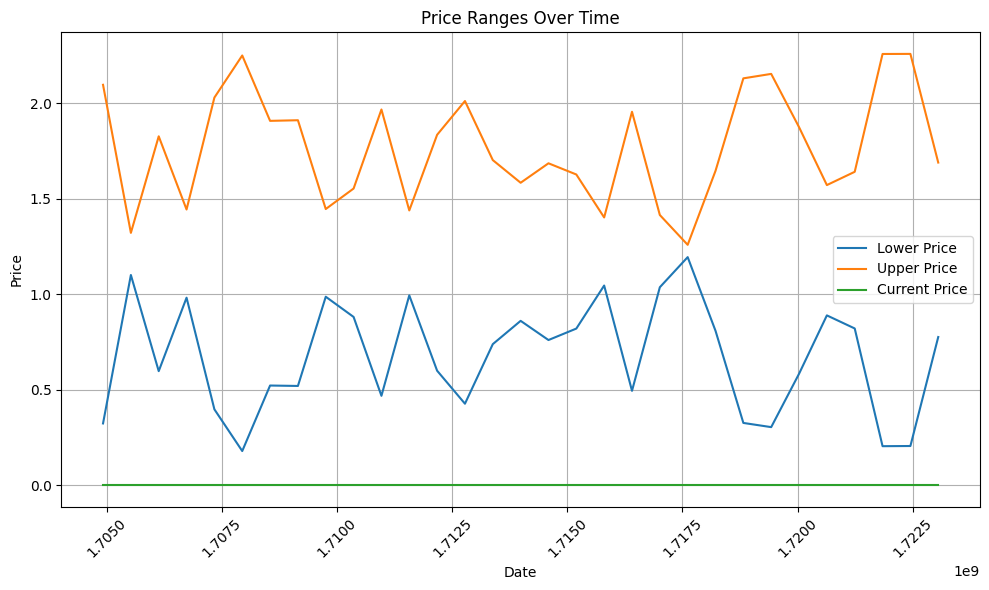

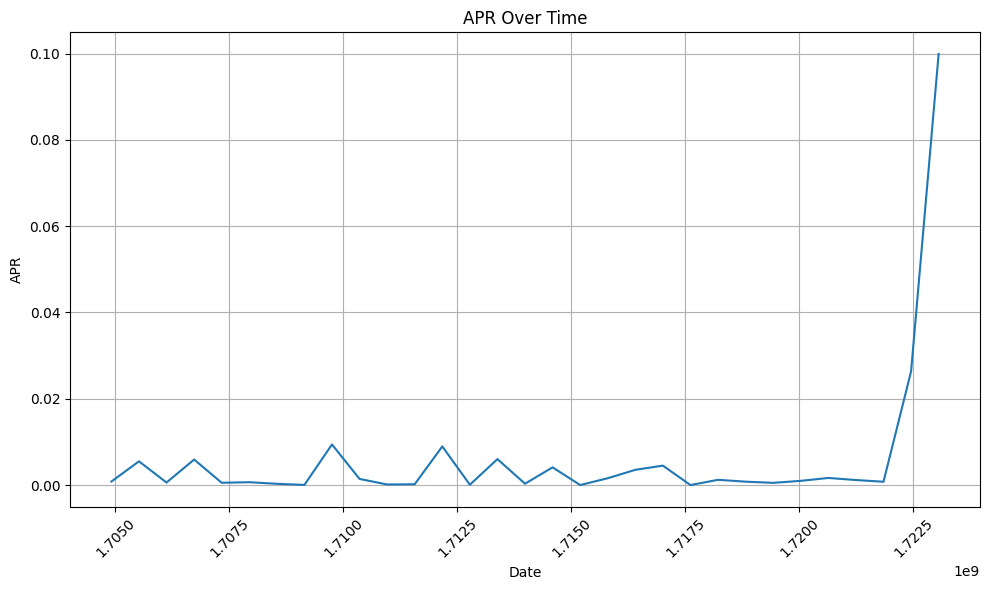

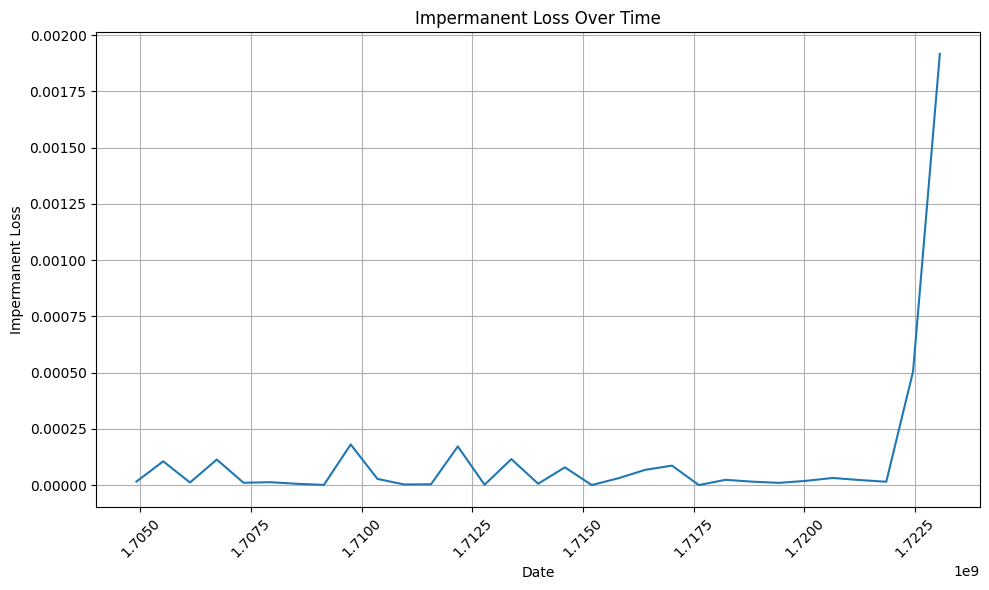

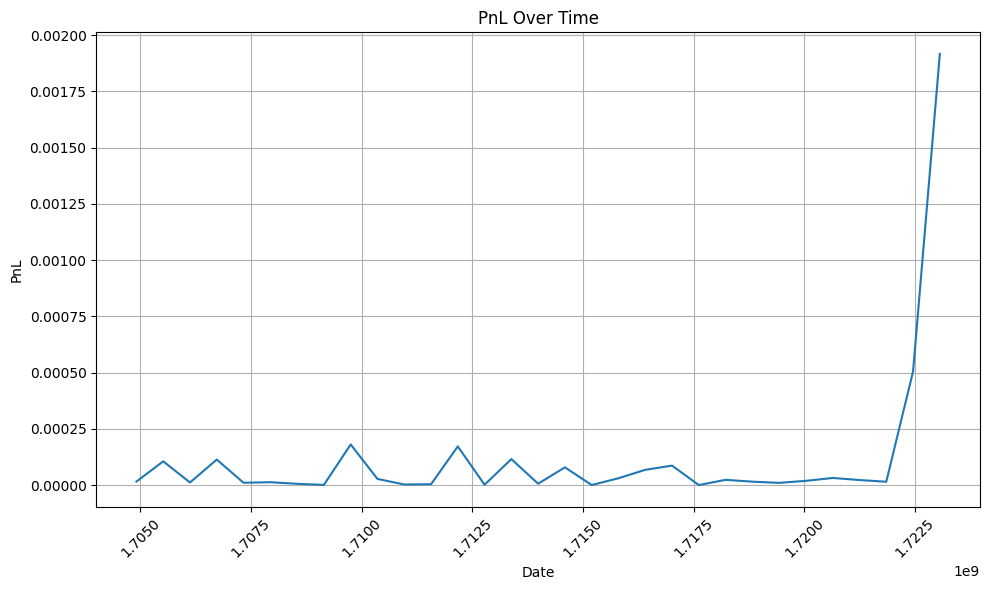

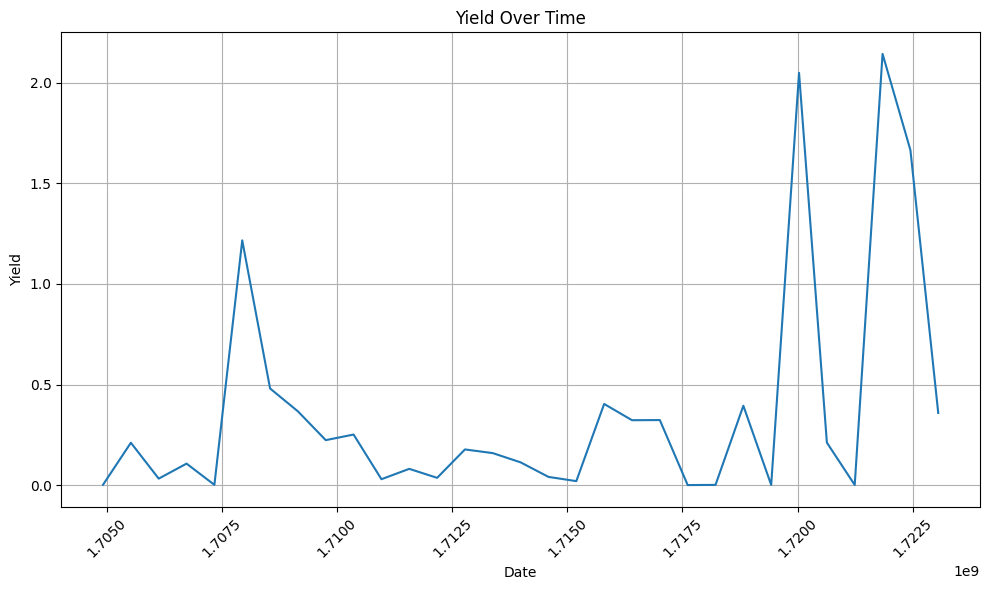

In [75]:

# Plotting the results
plot_prices_over_time(data_df)
plot_apr_over_time(data_df)
plot_il_over_time(data_df)
plot_pnl_over_time(data_df)
plot_yield_over_time(data_df)
